In [1]:
import numpy as np
import sunpy 
import sunpy.map
from sunpy.coordinates import (propagate_with_solar_surface, 
                               Helioprojective, 
                               get_horizons_coord)
import eispac
from glob import glob
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import astropy.constants as const
from sunraster.instr.spice import read_spice_l2_fits
import os
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
from sun_blinker import SunBlinker
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord)
import h5py

In [2]:
eui_files = sorted(glob("../../../../src/EUI/HRI/euv174/20221022/coalign_step_boxcar/*.fits"))
hri_map = sunpy.map.Map(eui_files[181])
hri_map.meta['rsun_ref'] = 696000000

In [3]:
Txshift_hri, Tyshift_hri = (6.6003 - 0)*u.arcsec, (8.15779-0)*u.arcsec

In [4]:
hri_map = hri_map.shift_reference_coord(Txshift_hri, Tyshift_hri)

In [5]:
spice_coalign_filename = '../../../../src/SPICE/20221022/lvl2/solo_L2_spice-n-ras_20221022T205536_V06_150995382-000_coalign.fits'
spice_coalign_cube = read_spice_l2_fits(spice_coalign_filename)

Set MJD-OBS to 59874.871951 from DATE-OBS.
Set MJD-BEG to 59874.871951 from DATE-BEG.
Set MJD-AVG to 59874.950052 from DATE-AVG.
Set MJD-END to 59875.028152 from DATE-END'. [astropy.wcs.wcs]


In [11]:
spice_time = spice_coalign_cube['Ne VIII 770 - Peak'].time[0]

In [6]:
spice_coalign_wcs = spice_coalign_cube['Ne VIII 770 - Peak'].wcs.dropaxis(2)[:,120:700,:]

In [7]:
saffron_dir = '../../../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221022T205536_V06_150995382-000/con-06/'

In [8]:
def interpolate_spice_map_to_target_wcs(spice_map, spice_coalign_wcs, spice_time, target_wcs):
    spice_nx = spice_nt = spice_map.data.shape[1]
    spice_map = spice_map.submap([0, 120]*u.pix, top_right=[spice_nx, 699]*u.pix)
    spice_ny = spice_map.data.shape[0]
    spice_pix_t, spice_pix_y, spice_pix_x = np.indices((1,*spice_map.data.shape))
    spice_world_coords = spice_coalign_wcs.pixel_to_world(spice_pix_x, spice_pix_y, spice_pix_t)[0][0,:,:]

    solar_orbiter_loc = np.flip(get_horizons_coord('solar orbiter',
                                                {'start':spice_time[-1],
                                                'stop':spice_time[0],
                                                'step':f'{spice_nt}'}))
    
    spice_pix_y_in_target_wcs = np.zeros((spice_ny, spice_nx))
    spice_pix_x_in_target_wcs = np.zeros((spice_ny, spice_nx))

    for ii in range(spice_nt):
        spice_world_coord_t = SkyCoord(spice_world_coords[:,ii].Tx.to(u.arcsec), 
                                  spice_world_coords[:,ii].Ty.to(u.arcsec),
                                  frame='helioprojective',obstime=spice_time[ii], 
                                  observer=solar_orbiter_loc[ii], 
                                  rsun=hri_map.meta['rsun_ref']*u.m,)
        
        with propagate_with_solar_surface(rotation_model='rigid'):
            spice_pix_x_in_target_wcs[:,ii], spice_pix_y_in_target_wcs[:,ii] = target_wcs.world_to_pixel(spice_world_coord_t)

    hri_map_pix_y, hri_map_pix_x = np.indices(hri_map.data.shape)

    spice_map_interpolator = LinearNDInterpolator((spice_pix_x_in_target_wcs.flatten(), spice_pix_y_in_target_wcs.flatten()), spice_map.data.flatten())

    spice_map_interpolated = spice_map_interpolator(hri_map_pix_x, hri_map_pix_y)

    return sunpy.map.Map(spice_map_interpolated, hri_map.wcs)

In [9]:
def get_saffron_map(saffron_dir, saffron_filename, spice_cube_wcs, spice_time, hri_map, velmap=False):
    saffron_files = glob(os.path.join(saffron_dir, saffron_filename))

    saffron_intmaps = []
    if velmap:
        saffron_velmaps = []

    for saffron_file in saffron_files:
        saffron_map = sunpy.map.Map(saffron_file)
        saffron_intmap = saffron_map[0]
        saffron_intmap = interpolate_spice_map_to_target_wcs(saffron_intmap, spice_cube_wcs, spice_time, hri_map.wcs)

        saffron_intmap.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(saffron_intmap.data, 0.5),
                                                                vmax=np.nanpercentile(saffron_intmap.data, 99.5),
                                                                stretch=AsinhStretch())
        saffron_intmaps.append(saffron_intmap)


        if velmap:
            saffron_velmap = saffron_map[1]

            saffron_velmap_data = saffron_velmap.data.copy()
            saffron_velmap_data = (saffron_velmap_data/np.nanmedian(saffron_velmap_data) - 1)*const.c.to_value(u.km/u.s)
            saffron_velmap_data = saffron_velmap_data - np.nanmedian(saffron_velmap_data[120:699,:], axis=0)
            saffron_velmap = sunpy.map.Map(saffron_velmap_data, saffron_map[1].meta)

            saffron_velmap = interpolate_spice_map_to_target_wcs(saffron_velmap, spice_cube_wcs, spice_time, hri_map.wcs)
            saffron_velmap.plot_settings['norm'] = ImageNormalize(vmin=-40, vmax=40)
            saffron_velmaps.append(saffron_velmap)

    if velmap:
        if len(saffron_files) == 1:
            return saffron_intmaps[0], saffron_velmaps[0]
        else:
            return saffron_intmaps, saffron_velmaps
    else:
        if len(saffron_files) == 1:
            return saffron_intmaps[0]
        else:
            return saffron_intmaps

In [12]:
saffron_NeVIII_intmap, saffron_NeVIII_velmap = get_saffron_map(saffron_dir, '*770.42-ne_8*.fits',
                                                                spice_coalign_wcs, spice_time, hri_map, velmap=True)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


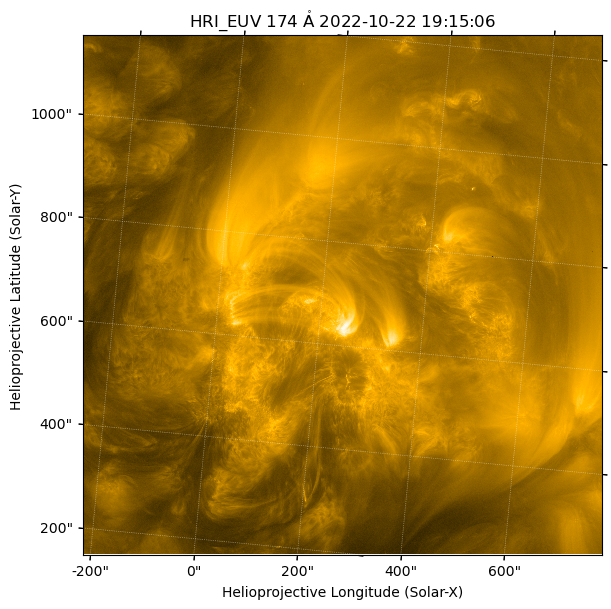

In [13]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)

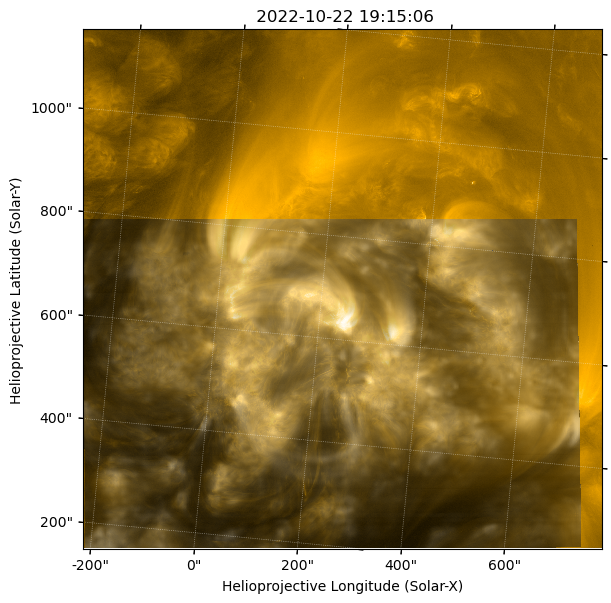

In [14]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_NeVIII_intmap.plot(axes=ax, alpha=0.5)

In [15]:
SunBlinker(hri_map, saffron_NeVIII_intmap)

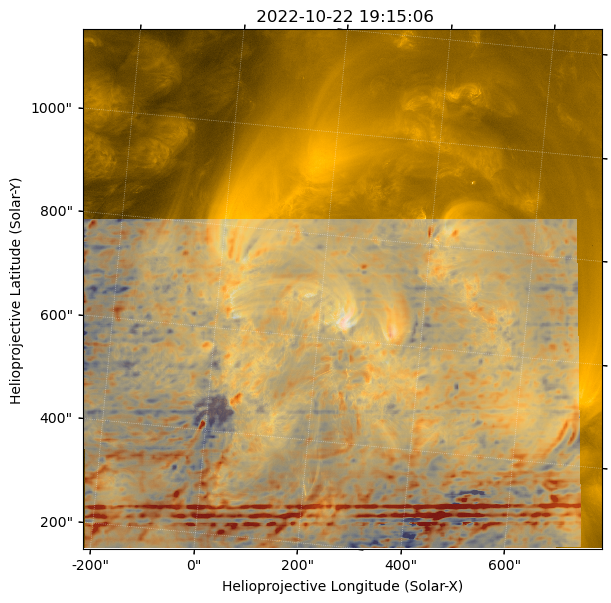

In [16]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_NeVIII_velmap.plot(axes=ax, alpha=0.5, cmap='coolwarm')

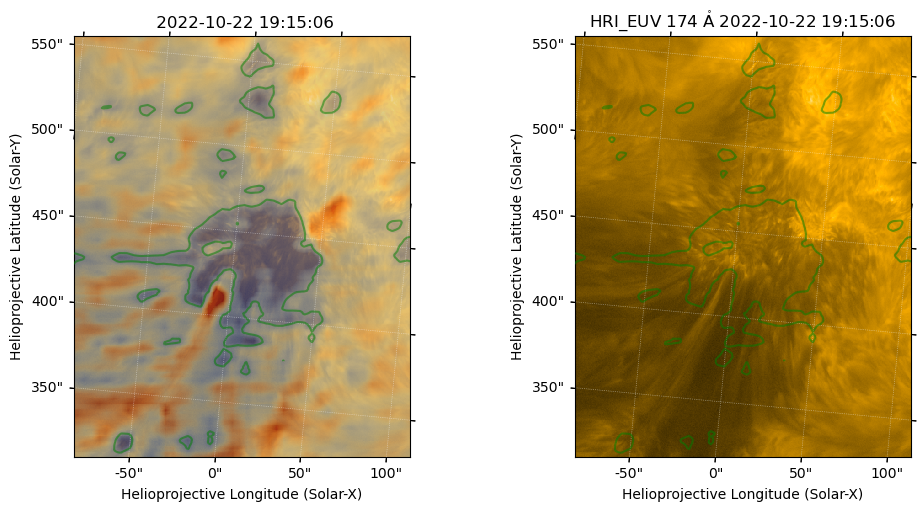

In [19]:
fig = plt.figure(figsize=(10,5),layout='constrained')
ax1 = fig.add_subplot(121,projection=hri_map.wcs)
hri_map.plot(axes=ax1)
saffron_NeVIII_velmap.plot(axes=ax1, alpha=0.5, cmap='coolwarm')

ax2 = fig.add_subplot(122,projection=hri_map.wcs)
hri_map.plot(axes=ax2)

for ax_ in (ax1,ax2):
    ax_.set_xlim(300, 700)
    ax_.set_ylim(300,800)
    saffron_NeVIII_velmap.draw_contours(levels=[-20],colors=["green"],alpha=0.5,
                                                                   axes=ax_,linestyles='solid')